In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/reviews/Reviews.csv


# Sentiment Analysis in Python

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

plt.style.use('ggplot')

In [3]:
#read in the data for reviews
df = pd.read_csv('/kaggle/input/reviews/Reviews.csv')

# since this is an example of sentiment analysis, we'll down sample the data from 568k to 1% (~568). 
print(df.shape)
df = df.head(568)
print(df.shape)



(568454, 10)
(568, 10)


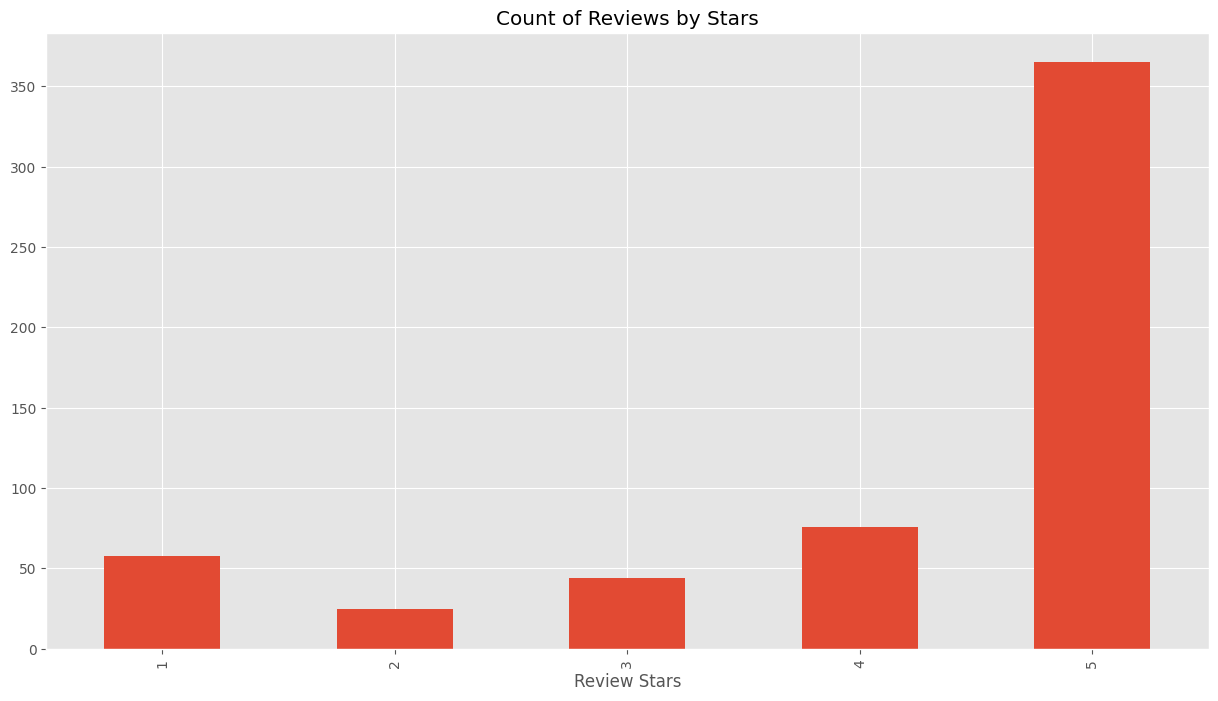

In [4]:
## some quick EDA

ax = df['Score'].value_counts().sort_index()\
    .plot(kind='bar', 
          title = 'Count of Reviews by Stars', 
          figsize = (15,8))
ax.set_xlabel('Review Stars')
plt.show()

In [5]:
# let's look at one of the comments to see how the NLTK library works. 

#create example
example = df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [6]:
# word tokenizer breaks out each word and assigns a token
tokens = nltk.word_tokenize(example)
print(tokens[:10])

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']


In [7]:
# run part of speech coding to understand how nltk is assigning a tag for what that word represents. 
tagged = nltk.pos_tag(tokens)
print(tagged[:10])

[('This', 'DT'), ('oatmeal', 'NN'), ('is', 'VBZ'), ('not', 'RB'), ('good', 'JJ'), ('.', '.'), ('Its', 'PRP$'), ('mushy', 'NN'), (',', ','), ('soft', 'JJ')]


In [8]:
# run chunking of text into groupings
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


## Using VADER (bag of words) approach.

In [9]:
from nltk.sentiment import SentimentIntensityAnalyzer 
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [10]:
#showing example of how sia works by passing in example of a positive statement. 
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [11]:
# run on our example
sia.polarity_scores(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [12]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row["Text"]
    myid = row["Id"]
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/568 [00:00<?, ?it/s]

In [13]:
# putting the resulting vader analysis into a dataframe and merging with original df. 
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index':'Id'})
vaders = vaders.merge(df,how = 'left')

In [14]:
# look at the first few rows of our new df
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.079,0.853,0.068,-0.1027,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


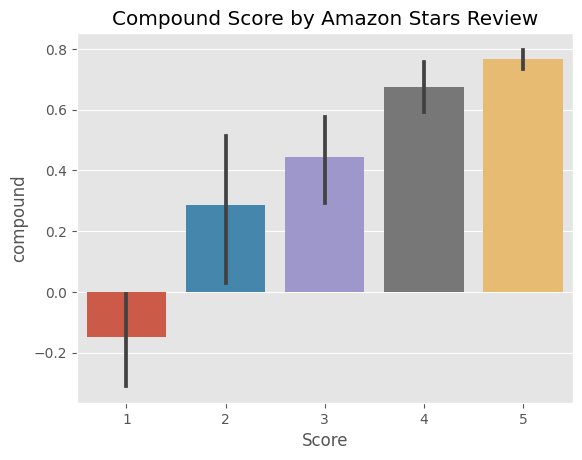

In [15]:
# making the assumption that a score of 5 is a positive review and let's validate with a quick review

#plot vader results

ax = sns.barplot(data= vaders, x='Score', y = 'compound')
ax.set_title('Compound Score by Amazon Stars Review')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

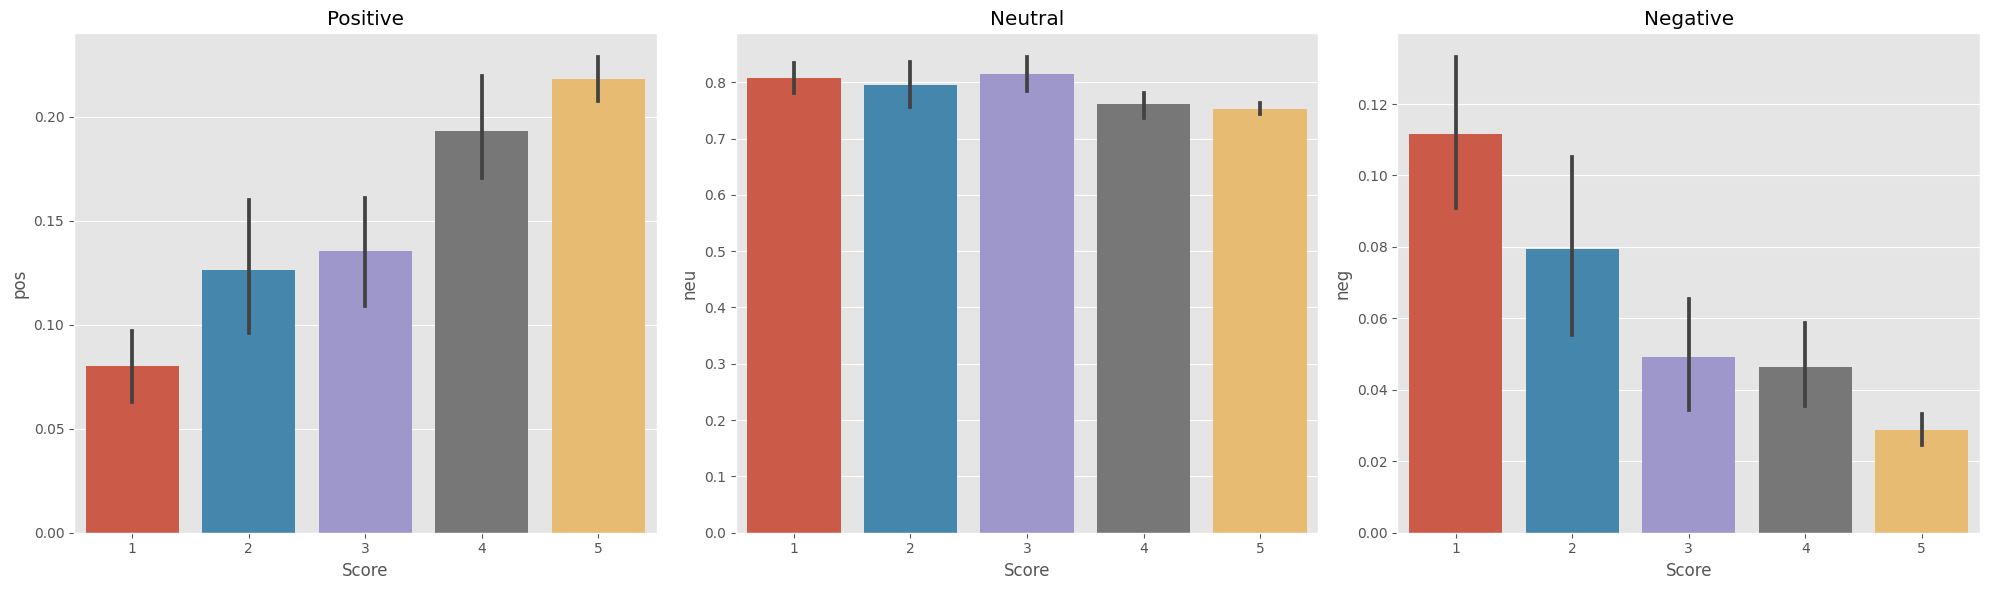

In [16]:
fig, axs = plt.subplots(1,3,figsize=(20,6))
sns.barplot(data=vaders, x='Score', y= 'pos', ax = axs[0])
sns.barplot(data=vaders, x='Score', y= 'neu', ax = axs[1])
sns.barplot(data=vaders, x='Score', y= 'neg', ax = axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show

## Roberta Pretrained Model

In [17]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [18]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [19]:
#VADER results on example
print(example)
sia.polarity_scores(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [20]:
#Roberta model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg': scores[0],
    'roberta_neu': scores[1],
    'roberta_pos': scores[2]
}
print(scores_dict)

{'roberta_neg': 0.97635514, 'roberta_neu': 0.020687465, 'roberta_pos': 0.0029573692}


In [21]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[2]
    }
    return scores_dict




In [22]:
# Run the polarity score on the entire dataset 
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row["Text"]
        myid = row["Id"]
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
                vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both_result = {**vader_result, **roberta_result}
        res[myid] = both_result
    except RuntimeError:
        print(f'Broke for id {myid}')
   

  0%|          | 0/568 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187
Broke for id 529
Broke for id 540


In [23]:
# putting the resulting analysis into a dataframe and merging with original df. 
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index':'Id'})
results_df = results_df.merge(df,how = 'left')

In [24]:
results_df.head()

,Id,neg,neu,pos,compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.079,0.853,0.068,-0.1027,0.508986,0.452414,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Compare score between models

In [25]:
results_df.columns

Index(['Id', 'neg', 'neu', 'pos', 'compound', 'roberta_neg', 'roberta_neu',
       'roberta_pos', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'Text'],
      dtype='object')

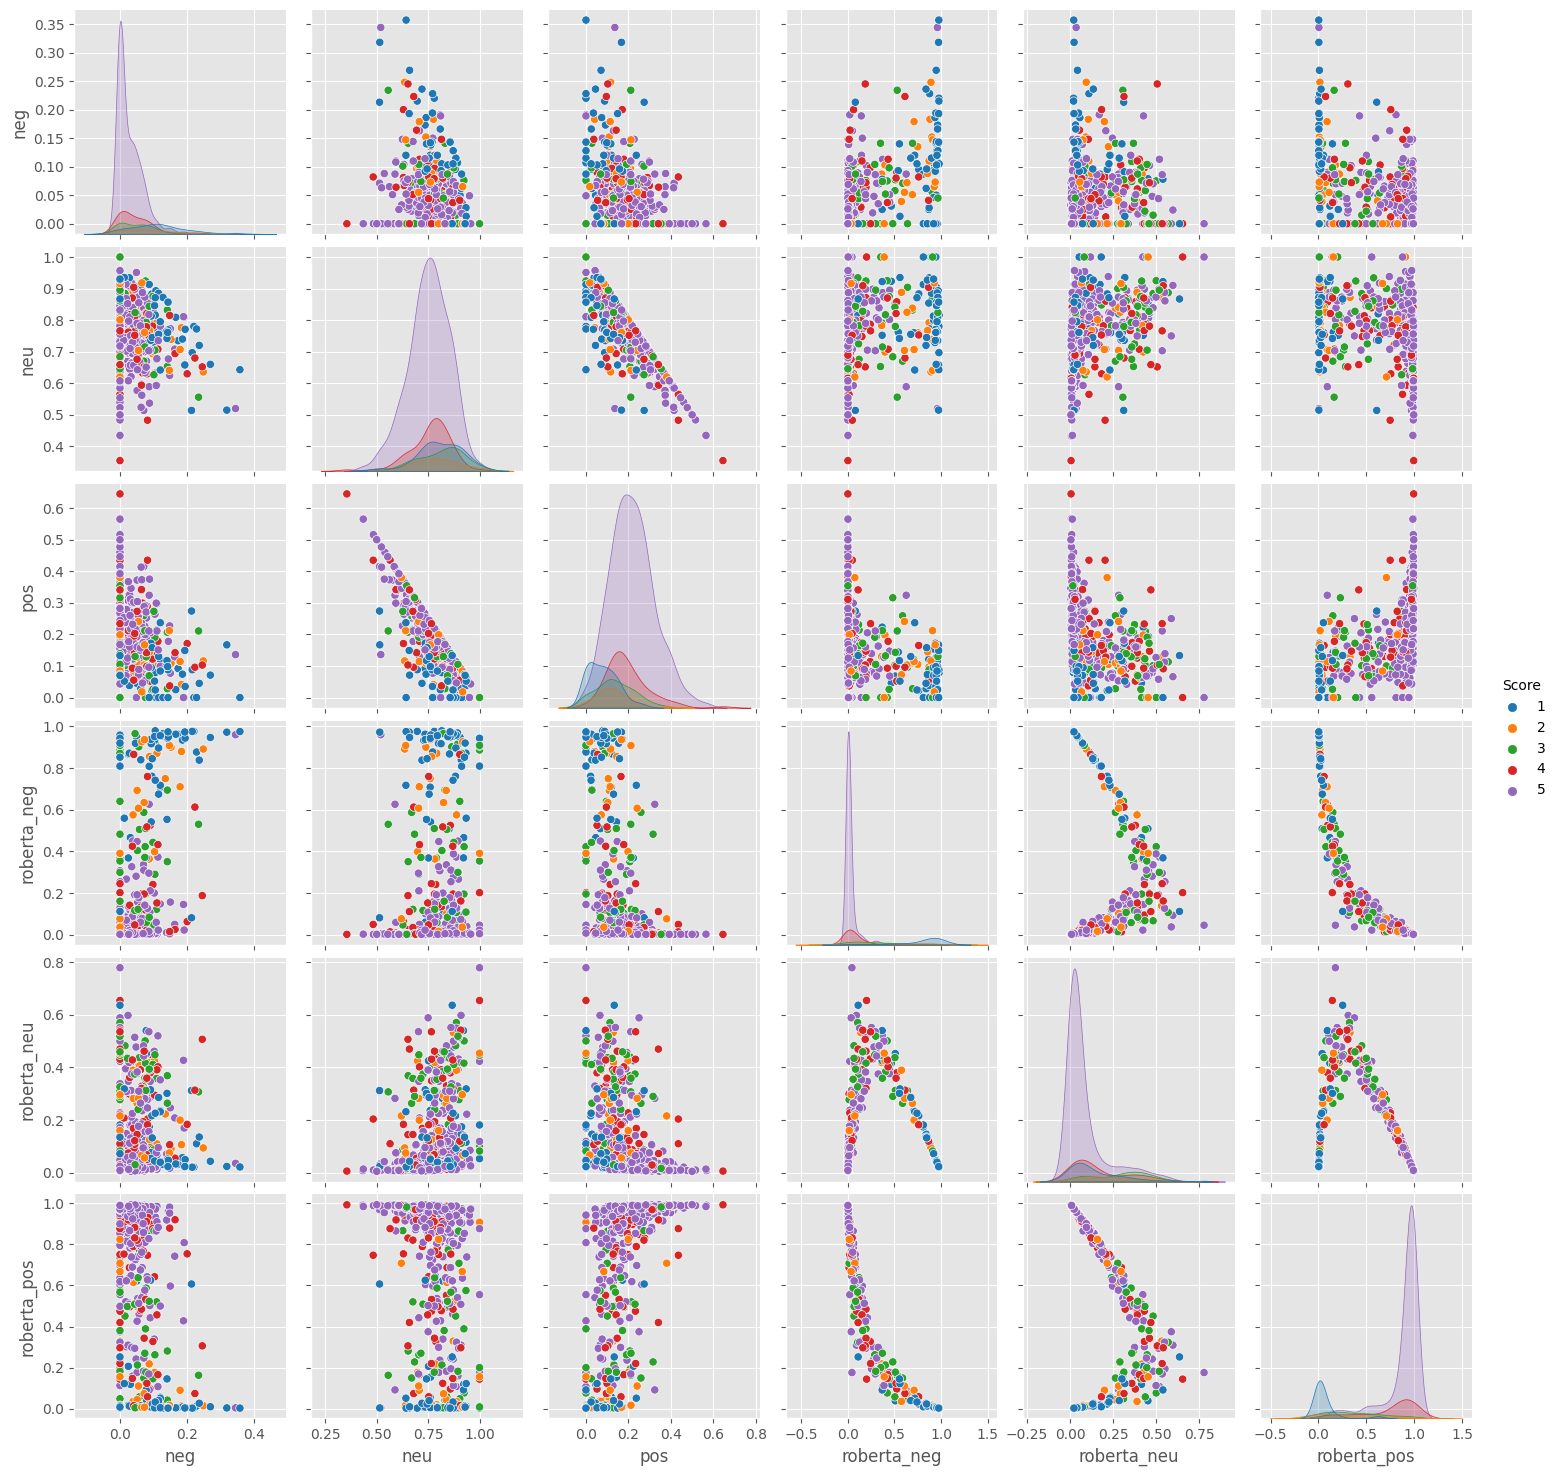

In [26]:
feature_set = ['neg', 'neu', 'pos', 'roberta_neg', 'roberta_neu', 'roberta_pos']

sns.pairplot(data = results_df, vars = feature_set, hue = "Score", palette = 'tab10')
plt.show()

## Review some examples

In [27]:
results_df.query('Score == 1').sort_values('roberta_pos', ascending = False)['Text'].values[0]

'I felt energized within five minutes, but it lasted for about 45 minutes. I paid $3.99 for this drink. I could have just drunk a cup of coffee and saved my money.'

In [28]:
results_df.query('Score == 1').sort_values('pos', ascending = False)['Text'].values[0]

'So we cancelled the order.  It was cancelled without any problem.  That is a positive note...'

In [29]:
results_df.query('Score == 5').sort_values('roberta_neg', ascending = False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

In [30]:
results_df.query('Score == 5').sort_values('neg', ascending = False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

## Use the Transformers pipeline

In [31]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [32]:
sent_pipeline('I love sentiment analysis!')

[{'label': 'POSITIVE', 'score': 0.9997853636741638}]

In [33]:
sent_pipeline('that was so delicious, but too bad I ate them too fast and gained 2 pounds. my fault!')

[{'label': 'NEGATIVE', 'score': 0.9873092770576477}]

In [34]:
sent_pipeline('The customer service reprepsentative was rude, but the quality of the work was exceptional!')

[{'label': 'POSITIVE', 'score': 0.999735414981842}]